# Human Action Detection

## Data Preprocessing

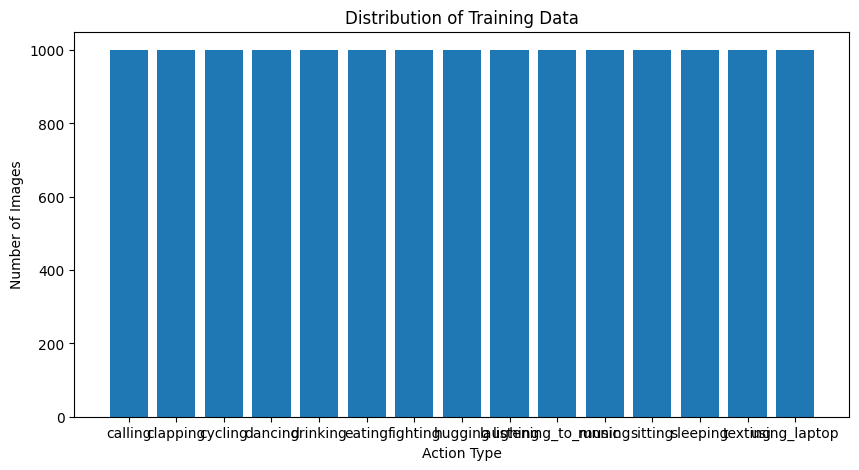

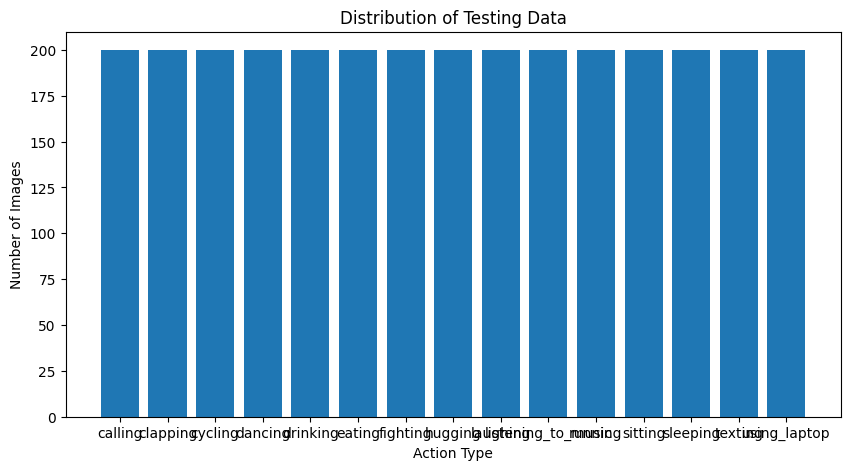

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter

path = 'emirhan_human_dataset/datasets/human_data'
train_data_path = path + '/train_data'
test_data = path + '/test_data'

def analyze_dataset(path, title):
    # get the list of all the files in the subfolders
    data_files = os.listdir(path)
    categories = []
    for file in data_files: 
        if os.path.isdir(path + '/' + file):
            categories.append(file)

    # then I want to get a count of the number of files in each of the subfolders
    action_type_counts = {}
    for action in categories:
        action_type_counts[action] = len(os.listdir(path + '/' + action))

    plt.figure(figsize=(10, 5))
    plt.bar(action_type_counts.keys(), action_type_counts.values())
    plt.xlabel('Action Type')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

analyze_dataset(train_data_path, title="Distribution of Training Data") 
analyze_dataset(test_data, "Distribution of Testing Data")

## Model

In [17]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

# Data preparation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "emirhan_human_dataset/datasets/human_data/train_data",
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    "emirhan_human_dataset/datasets/human_data/test_data",
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical')

base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='avg')
base_model.trainable = False  # Freeze the base model to not train it
inputs = base_model.input
x = Dense(64, activation='relu')(base_model.output)
x = Dense(64, activation='relu')(x)
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
model.fit(train_generator, validation_data=test_generator, epochs=5, callbacks=callbacks, verbose=1)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Epoch 1/5


c:\Users\zhxu3\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.3172 - loss: 2.1699 - val_accuracy: 0.5780 - val_loss: 1.3122
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.6360 - loss: 1.1324 - val_accuracy: 0.6070 - val_loss: 1.1890
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.6839 - loss: 0.9747 - val_accuracy: 0.6350 - val_loss: 1.1466
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 210ms/step - accuracy: 0.7193 - loss: 0.8733 - val_accuracy: 0.6510 - val_loss: 1.1213
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 206ms/step - accuracy: 0.7428 - loss: 0.7801 - val_accuracy: 0.6503 - val_loss: 1.1195


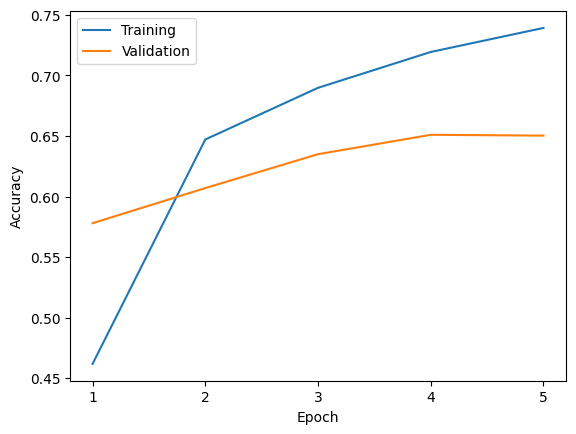

In [18]:
# Evaluate training and validation accuracy
history = model.history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
epochs = len(history['accuracy'])
plt.xticks(range(epochs), [str(i+1) for i in range(epochs)])
plt.legend(['Training', 'Validation'])
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step


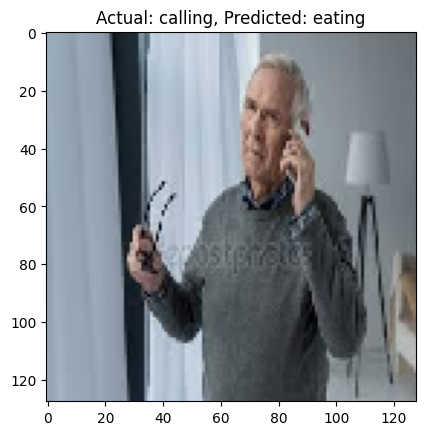

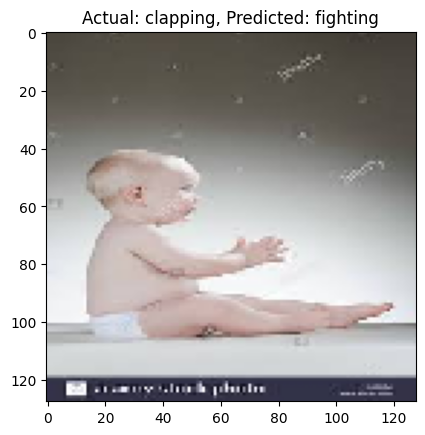

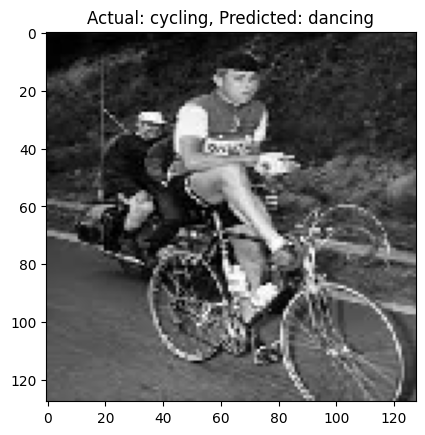

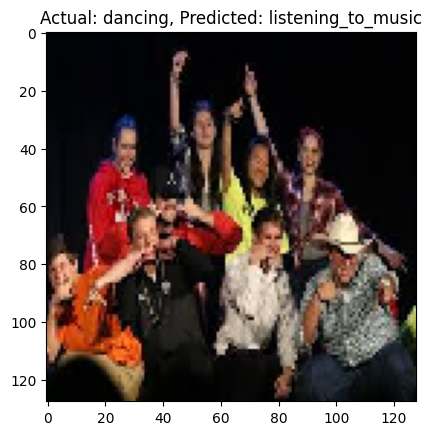

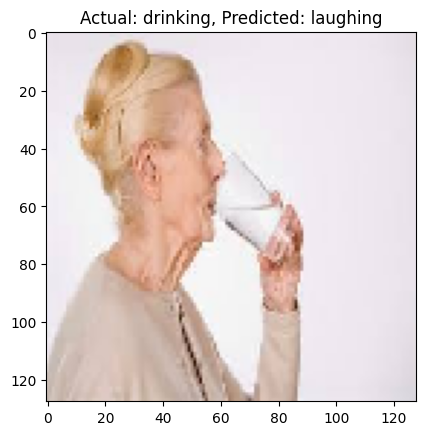

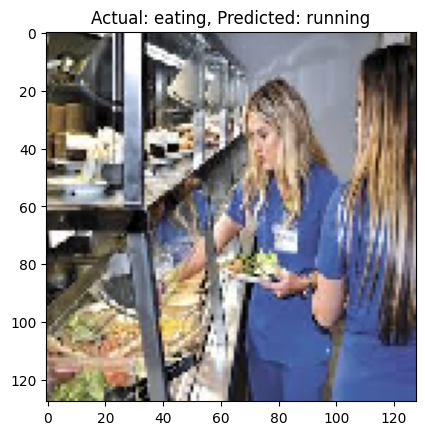

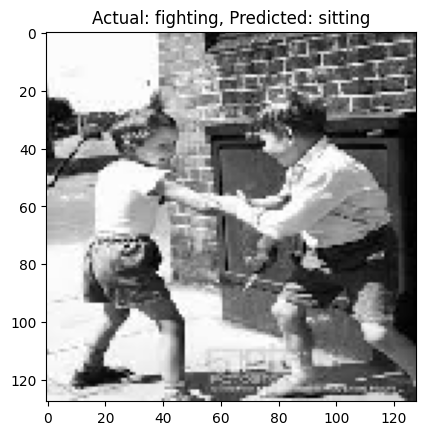

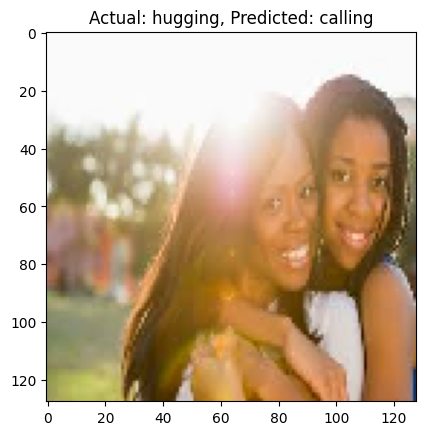

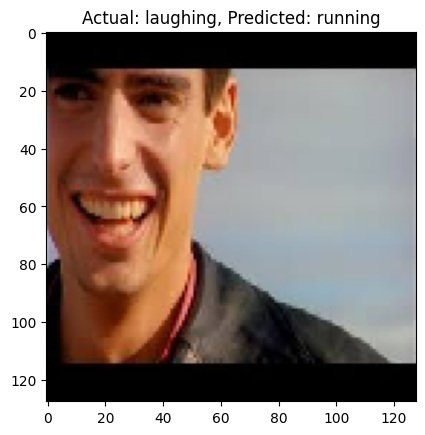

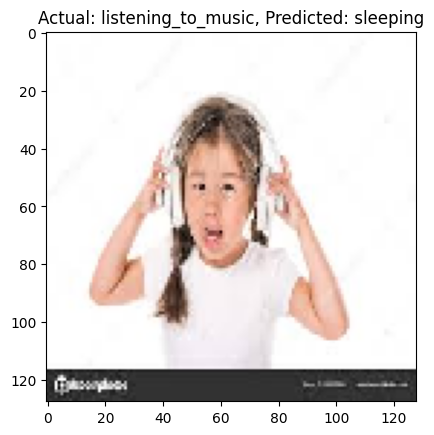

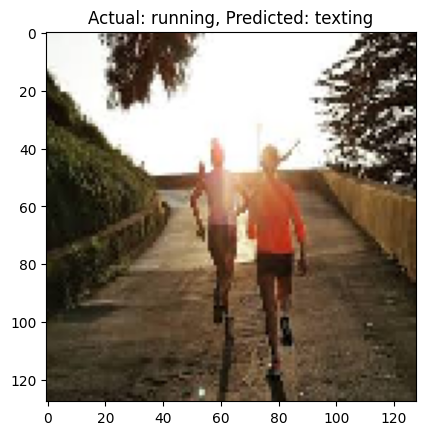

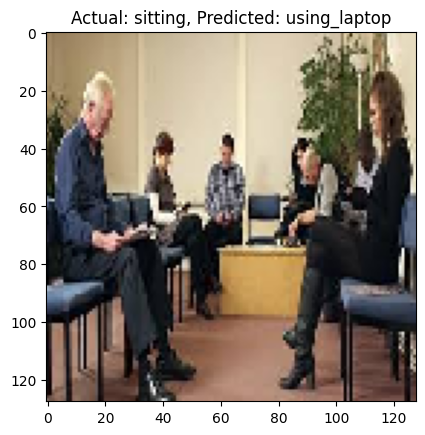

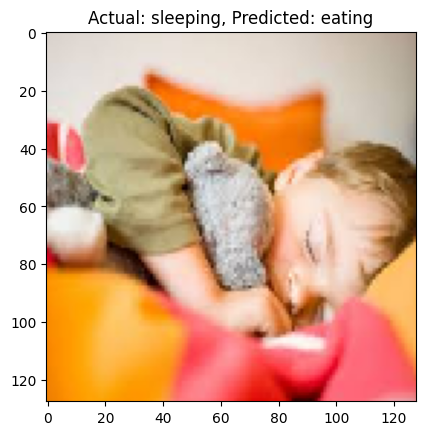

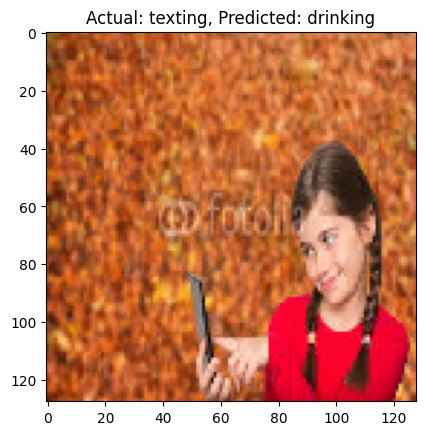

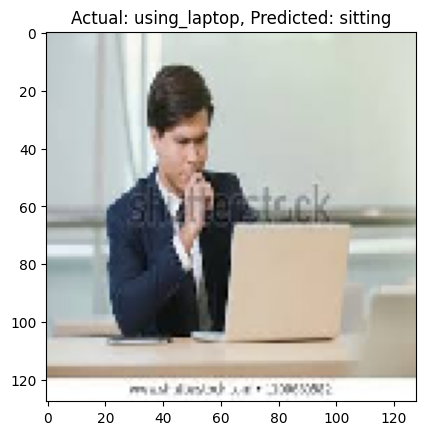

In [19]:
# Identify misclassified images for each class
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
misclassified_idxs = np.where(predicted_classes != true_classes)[0]
class_labels = list(test_generator.class_indices.keys())

shown_classes = {}
for idx in misclassified_idxs:
    true_class = class_labels[true_classes[idx]]
    predicted_class = class_labels[predicted_classes[idx]]
    if true_class not in shown_classes:
        shown_classes[true_class] = True
        img_path = test_generator.filepaths[idx]
        img = load_img(img_path, target_size=(128, 128))
        plt.imshow(img)
        plt.title(f'Actual: {true_class}, Predicted: {predicted_class}')
        plt.show()
    if len(shown_classes) == len(class_labels):
        break